In [1]:
import os
os.chdir("/home/mohsen/projects/scarches/")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import scanpy as sc
import numpy as np
import scarches as sca

/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.


In [4]:
sc.settings.set_figure_params(dpi=200)

In [5]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas SS2 (query)", "Pancreas CelSeq2 (query)"]
target_cell_types = ['Pancreas Alpha']

In [6]:
sc.settings.figdir = "./results/iterative_surgery_new/pancreas_alpha/"

# Loading 5 Pancreas datasets and data preparation

In [7]:
adata = sca.data.read("/home/mohsen/data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Number of cells in each batch

In [8]:
adata.obs[condition_key].replace("Pancreas inDrop", 'Pancreas InDrop', inplace=True)

In [9]:
adata.obs[condition_key].value_counts()

Pancreas InDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

In [10]:
adata.obs[condition_key].replace("Pancreas InDrop", "Pancreas InDrop (reference)", inplace=True)
adata.obs[condition_key].replace("Pancreas SS2", "Pancreas SS2 (query)", inplace=True)
adata.obs[condition_key].replace("Pancreas CelSeq2", "Pancreas CelSeq2 (query)", inplace=True)
adata.obs[condition_key].replace("Pancreas CelSeq", "Pancreas CelSeq (reference)", inplace=True)
adata.obs[condition_key].replace("Pancreas Fluidigm C1", "Pancreas Fluidigm C1 (reference)", inplace=True)

In [11]:
batch_colors_list = sc.pl.palettes.godsnot_102[10:15]
batch_colors_list

['#63FFAC', '#B79762', '#004D43', '#8FB0FF', '#997D87']

In [12]:
batch_colors = {}
for idx, batch in enumerate(adata.obs[condition_key].unique().tolist()):
    batch_colors[batch] = batch_colors_list[idx]

In [13]:
batch_colors

{'Pancreas InDrop (reference)': '#63FFAC',
 'Pancreas CelSeq2 (query)': '#B79762',
 'Pancreas CelSeq (reference)': '#004D43',
 'Pancreas Fluidigm C1 (reference)': '#8FB0FF',
 'Pancreas SS2 (query)': '#997D87'}

In [14]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata

View of AnnData object with n_obs × n_vars = 10294 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [15]:
source_adata = source_adata[~source_adata.obs[cell_type_key].isin(target_cell_types)]
source_adata

View of AnnData object with n_obs × n_vars = 7584 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [16]:
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
target_adata

View of AnnData object with n_obs × n_vars = 5387 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [17]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [20]:
palette = [batch_colors['Pancreas CelSeq (reference)'], 
           batch_colors['Pancreas CelSeq2 (query)'], 
           batch_colors['Pancreas Fluidigm C1 (reference)'],
           batch_colors['Pancreas InDrop (reference)'],
           batch_colors['Pancreas SS2 (query)']
          ]

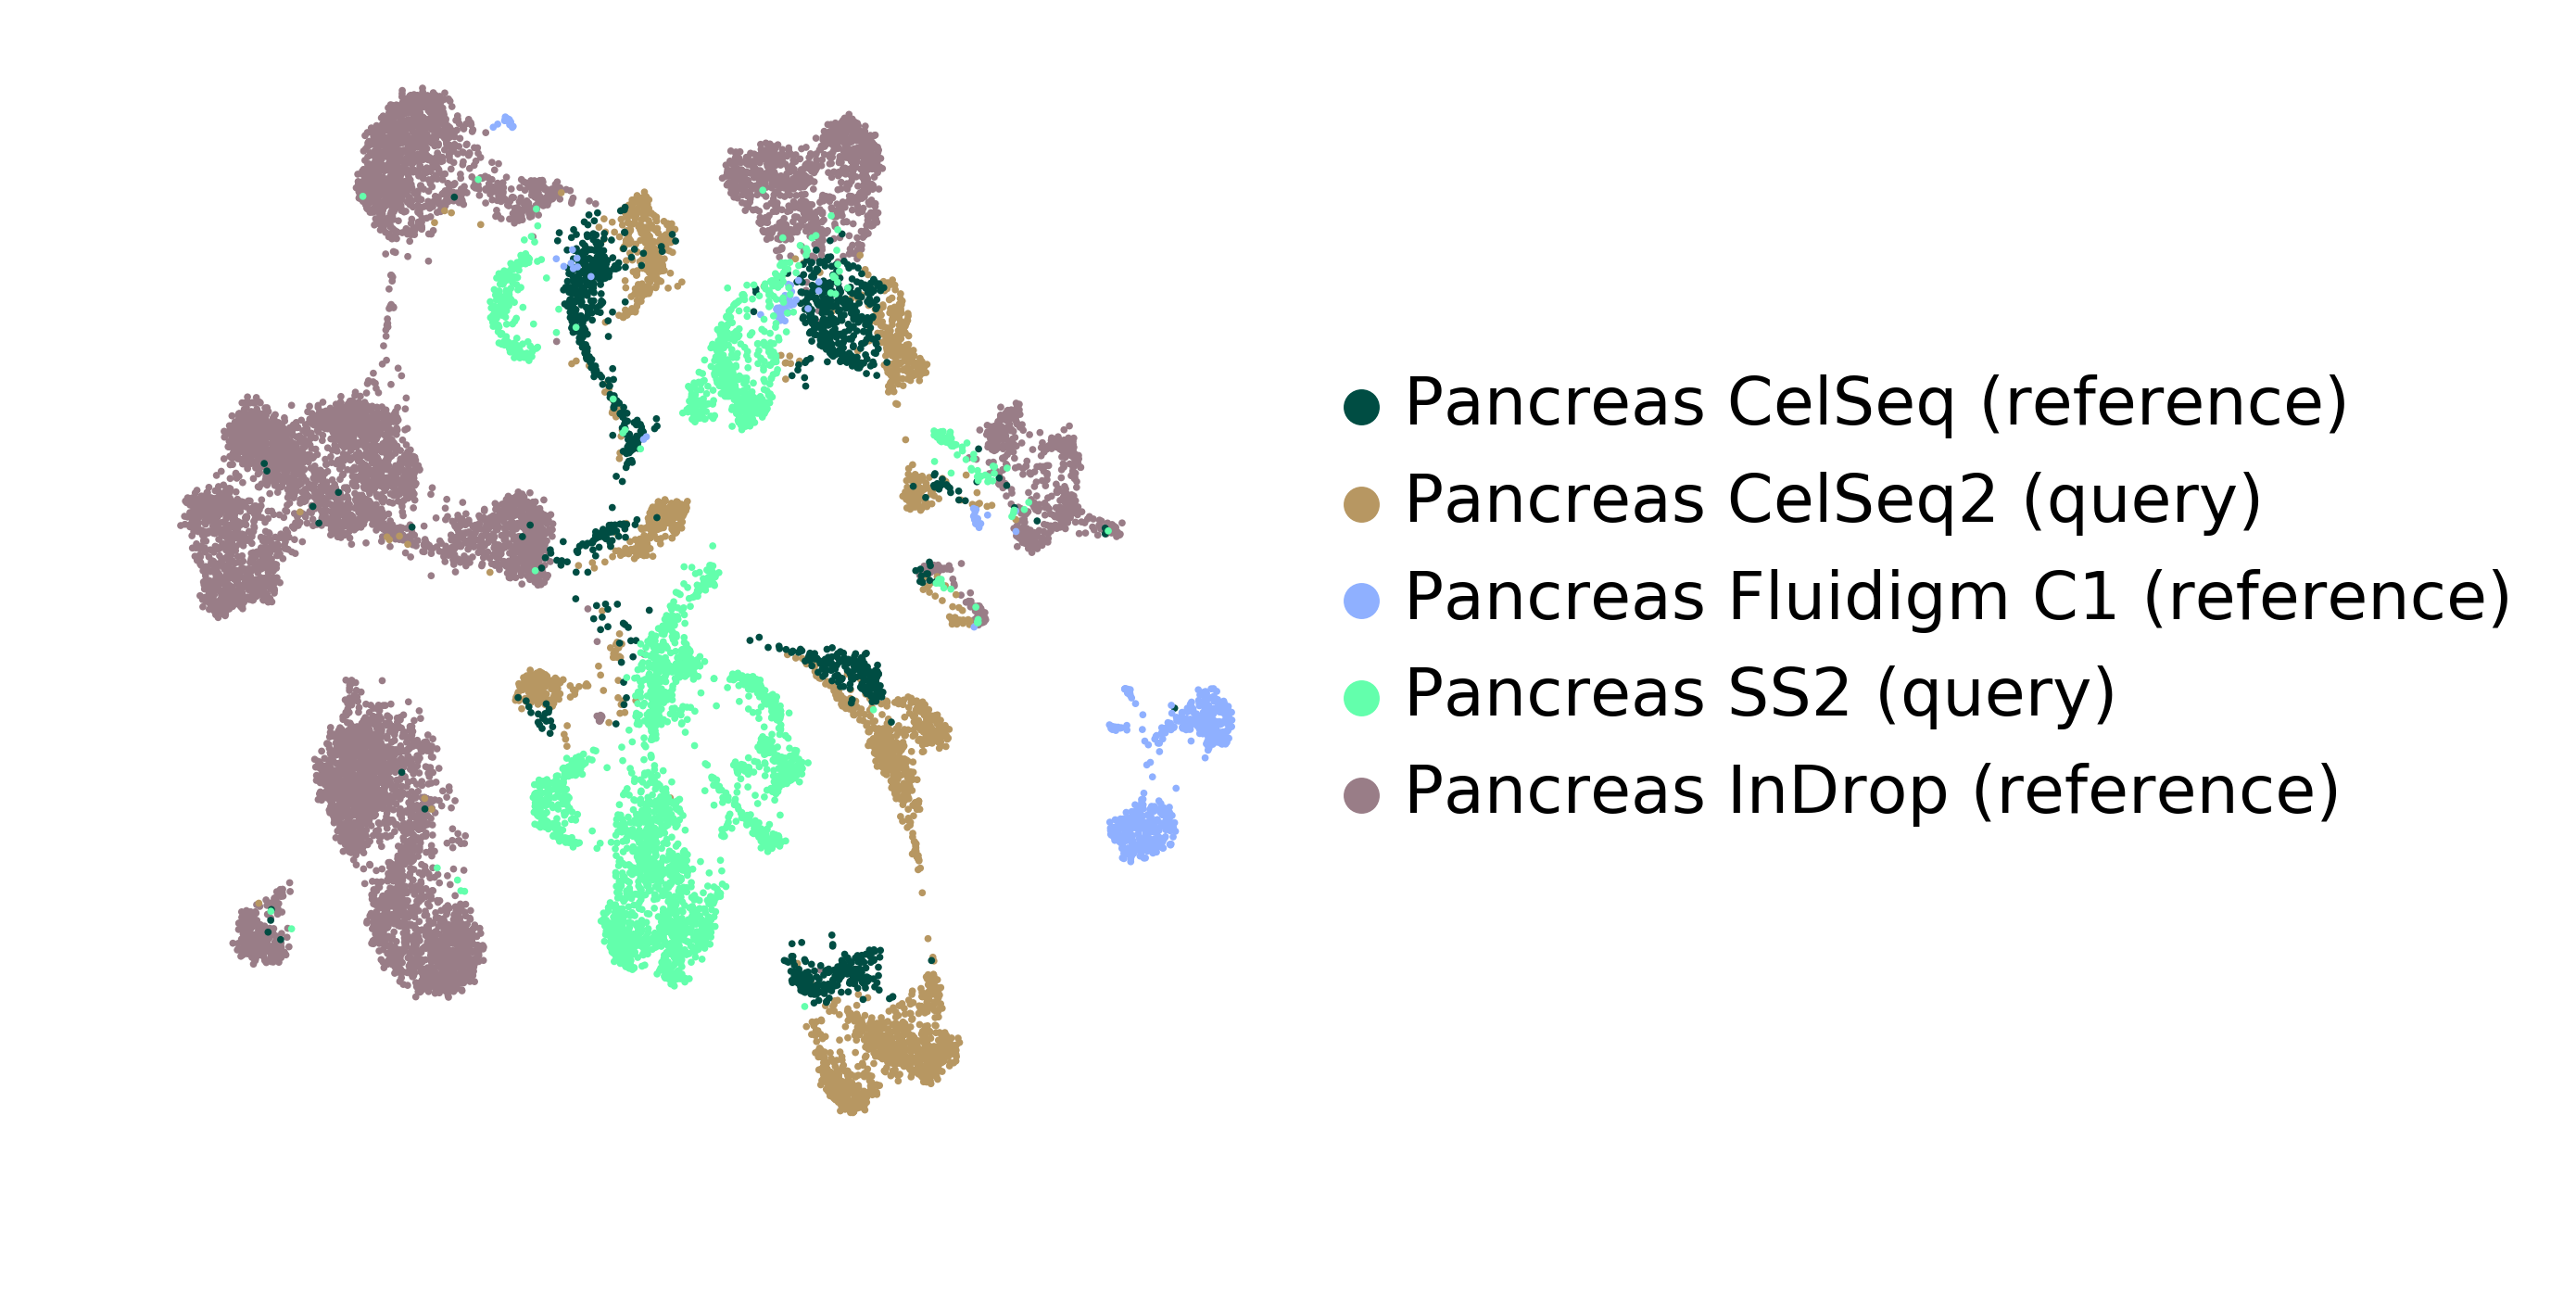

In [21]:
sc.pl.umap(adata, color=[condition_key], frameon=False, title="", palette=palette)

In [ ]:
sc.pp.neighbors(source_adata)
sc.tl.umap(source_adata)

In [17]:
palette = [batch_colors['Pancreas CelSeq'], 
           batch_colors['Pancreas Fluidigm C1'],
           batch_colors['Pancreas InDrop'],
          ]

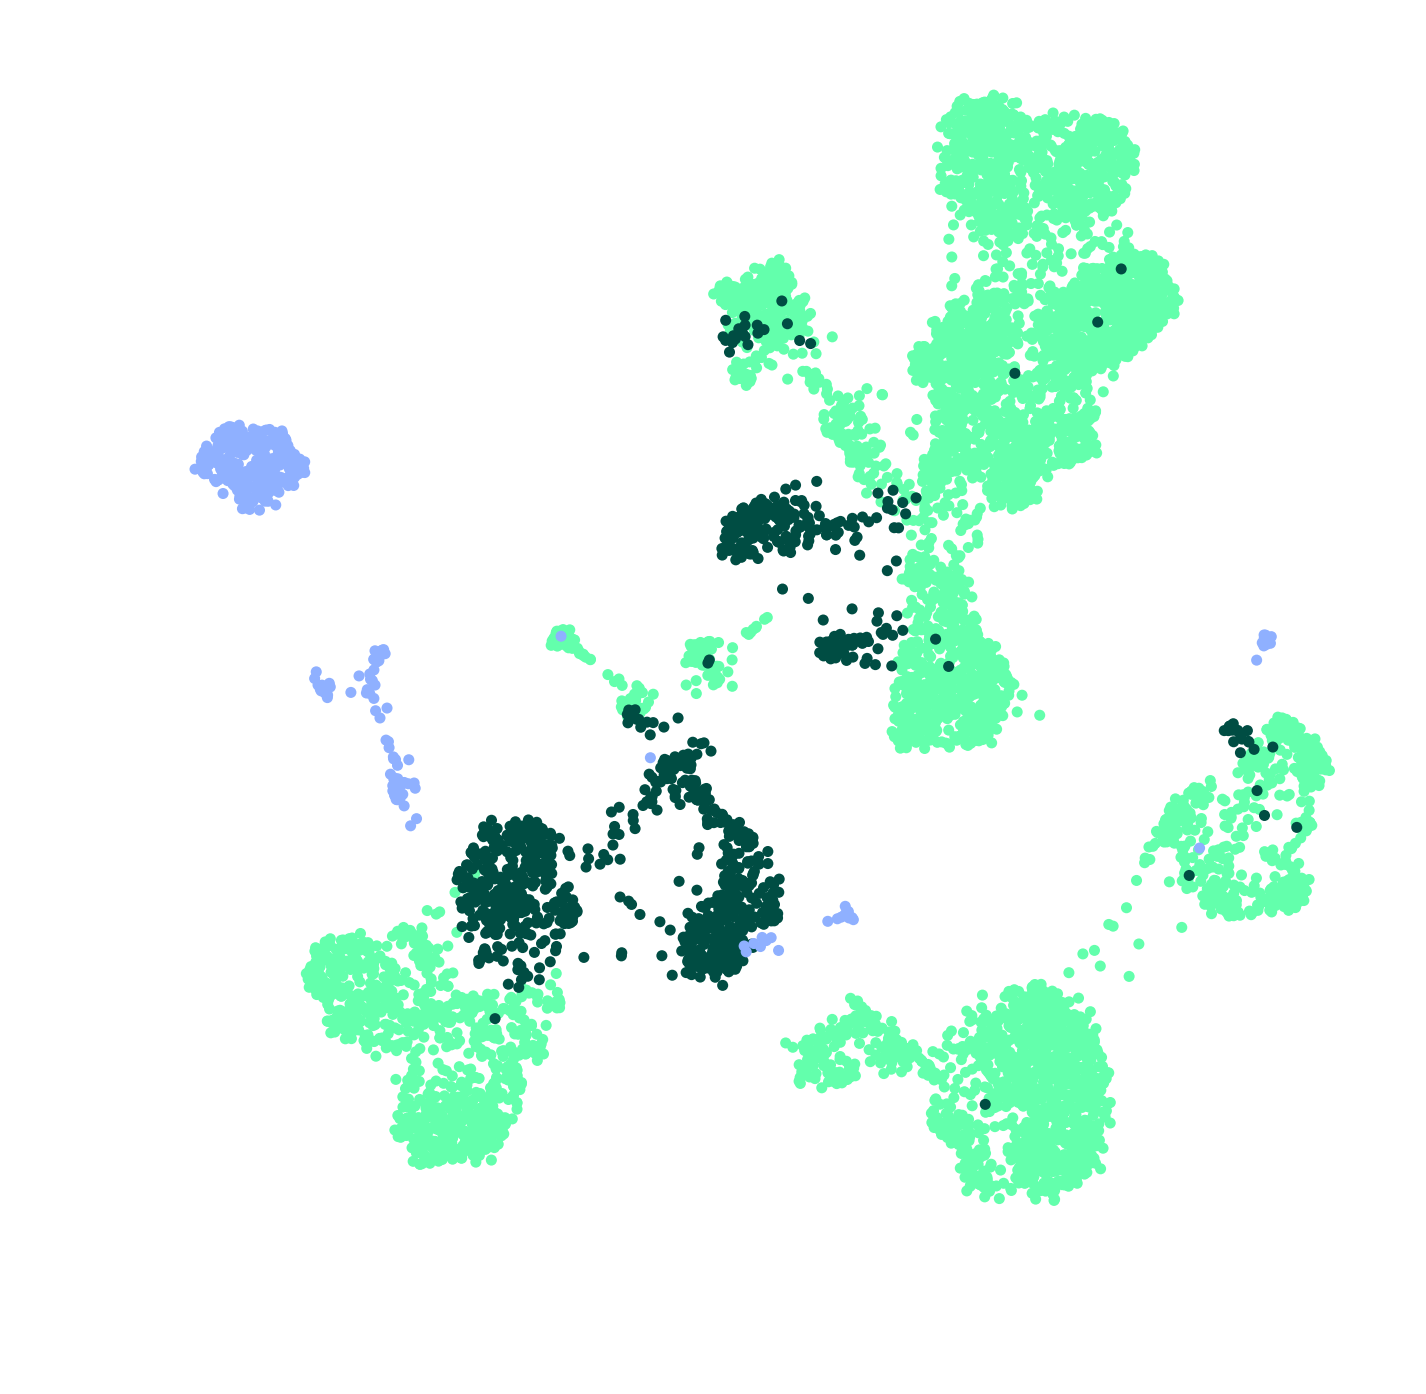

In [18]:
sc.pl.umap(source_adata, color=[condition_key], frameon=False, title="", legend_loc=None,
           save="_condition_original.pdf", palette=palette)

In [19]:
palette = sc.pl.palettes.godsnot_102[:1] + sc.pl.palettes.godsnot_102[2:]

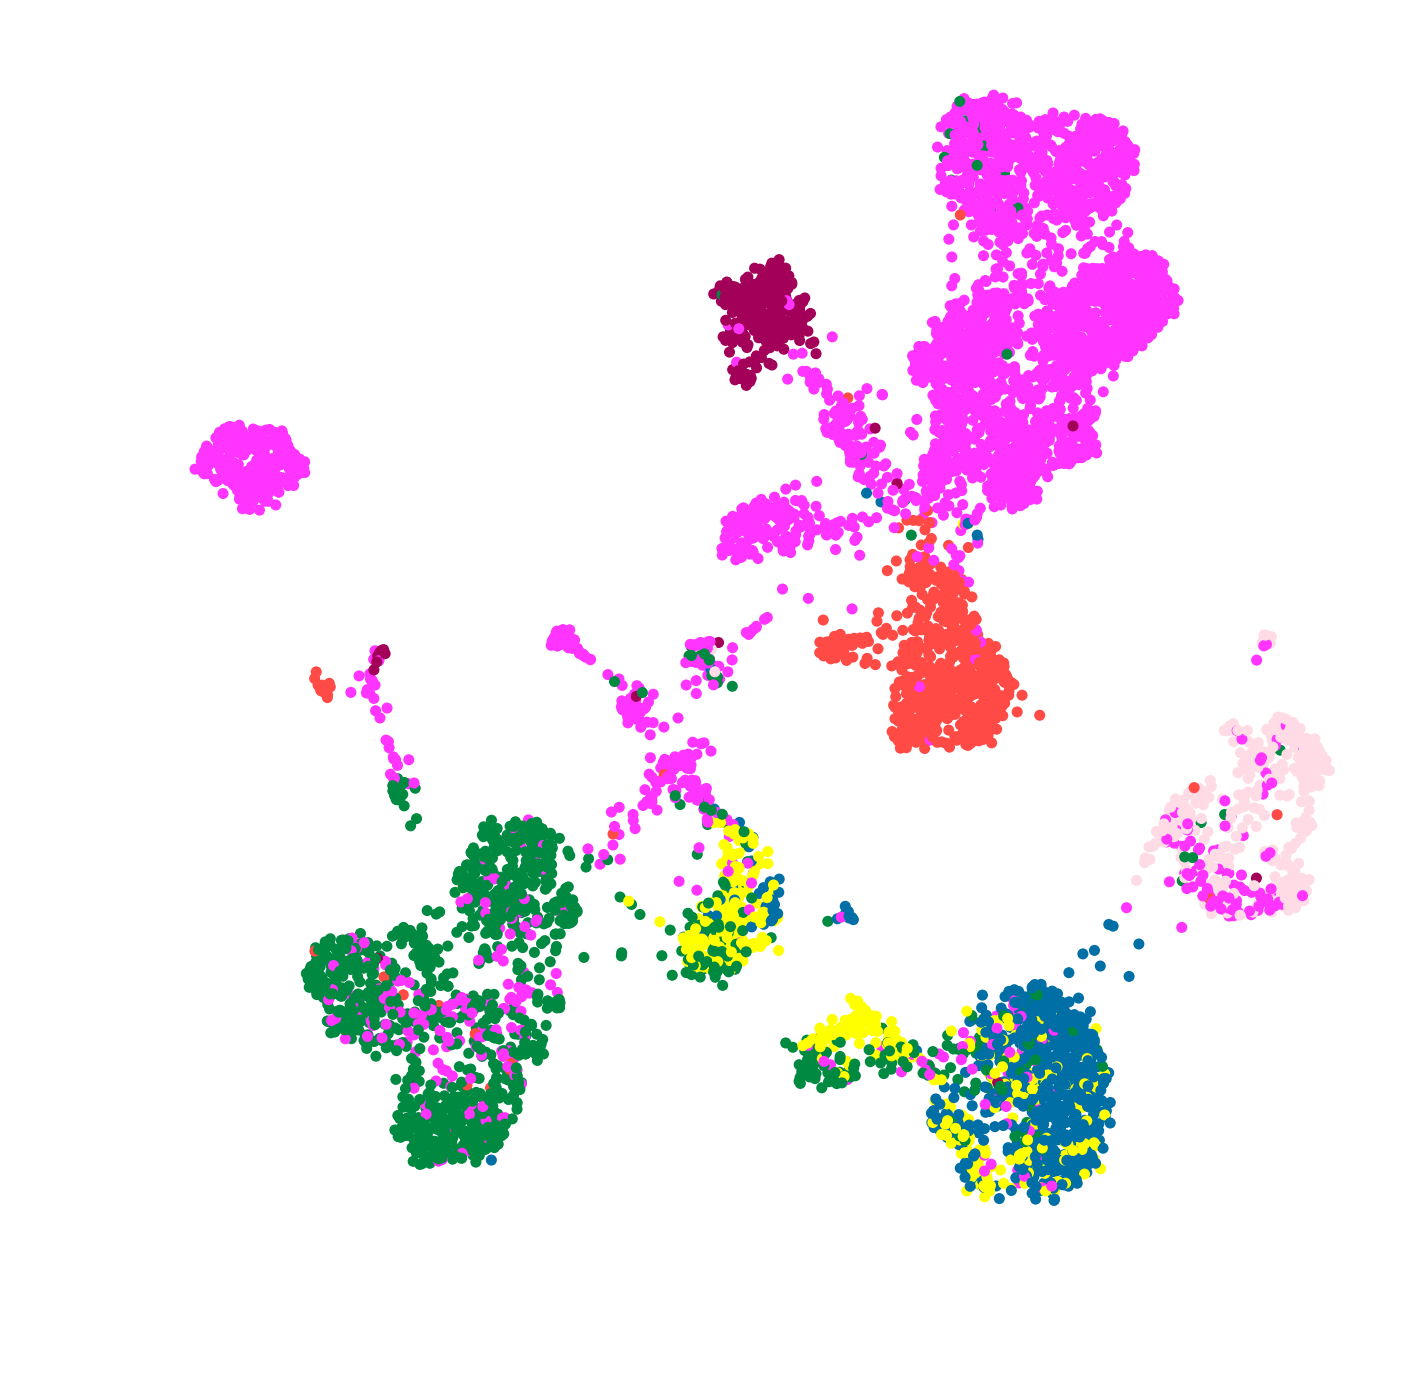

In [20]:
sc.pl.umap(source_adata, color=[cell_type_key], frameon=False, title="", legend_loc=None,
           save="_cell_type_original.pdf", palette=palette)

In [17]:
conditions = source_adata.obs[condition_key].unique().tolist()

# Create & Train model with training data

In [18]:
network = sca.models.scArches(task_name='pancreas_alpha', 
                              x_dimension=source_adata.shape[1], 
                              z_dimension=10,
                              gene_names=source_adata.var_names.tolist(),
                              architecture=[128, 20],
                              conditions=conditions,
                              use_batchnorm=False,
                              lr=0.001,
                              alpha=0.0001,
                              beta=200,
                              clip_value=1000,
                              eta=1.0,
                              loss_fn='mse',
                              model_path=f"./models/OoS+IS/pancreas_alpha/before/",
                              dropout_rate=0.05,
                              output_activation='relu')

W0726 15:27:51.417044 139747506444096 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0726 15:27:51.420636 139747506444096 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0726 15:27:51.422050 139747506444096 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0726 15:27:51.783488 139747506444096 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!


## Training the network

In [19]:
network.train(source_adata,
              train_size=0.8, 
              condition_key=condition_key,
              n_epochs=10000,
              batch_size=512, 
              early_stop_limit=50,
              lr_reducer=40, 
              save=True,
              retrain=True,
              )

W0726 15:27:55.184064 139747506444096 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0726 15:27:55.395495 139747506444096 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0726 15:27:55.625617 139747506444096 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0726 15:27:56.175794 139747506444096 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Plea

 |--------------------| 4.1%  - loss: 6.8186 - mmd_loss: 4.9348 - reconstruction_loss: 1.8837 - val_loss: 6.1702 - val_mmd_loss: 4.3219 - val_reconstruction_loss: 1.84834156
scArches has been successfully saved in ./models/OoS+IS/pancreas_alpha/before/unknown.


In [20]:
latent_adata = network.get_latent(source_adata, condition_key)
latent_adata

AnnData object with n_obs × n_vars = 7584 × 10 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [51]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [52]:
palette = [batch_colors['Pancreas CelSeq'], 
           batch_colors['Pancreas Fluidigm C1'],
           batch_colors['Pancreas InDrop']
          ]

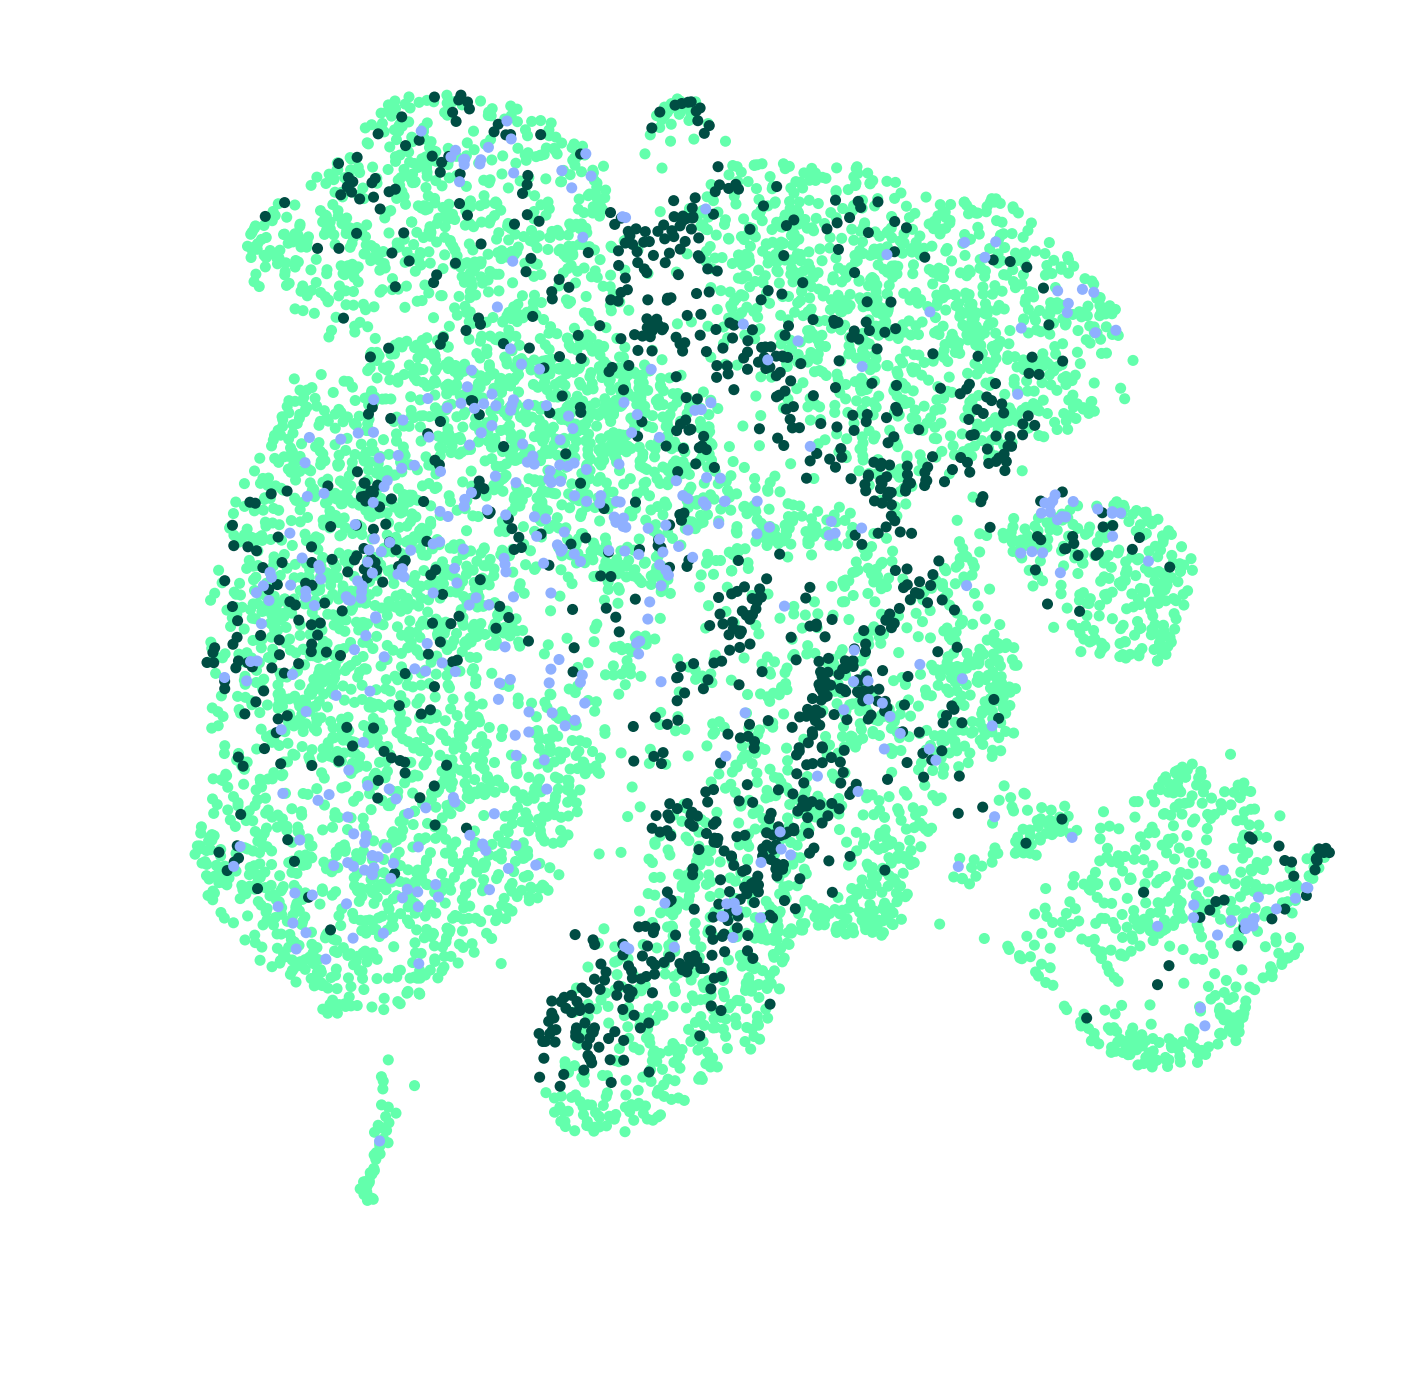

In [54]:
sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", 
           save="_condition_before.pdf", palette=palette, legend_loc=None)

In [55]:
palette = sc.pl.palettes.godsnot_102[:1] + sc.pl.palettes.godsnot_102[2:]

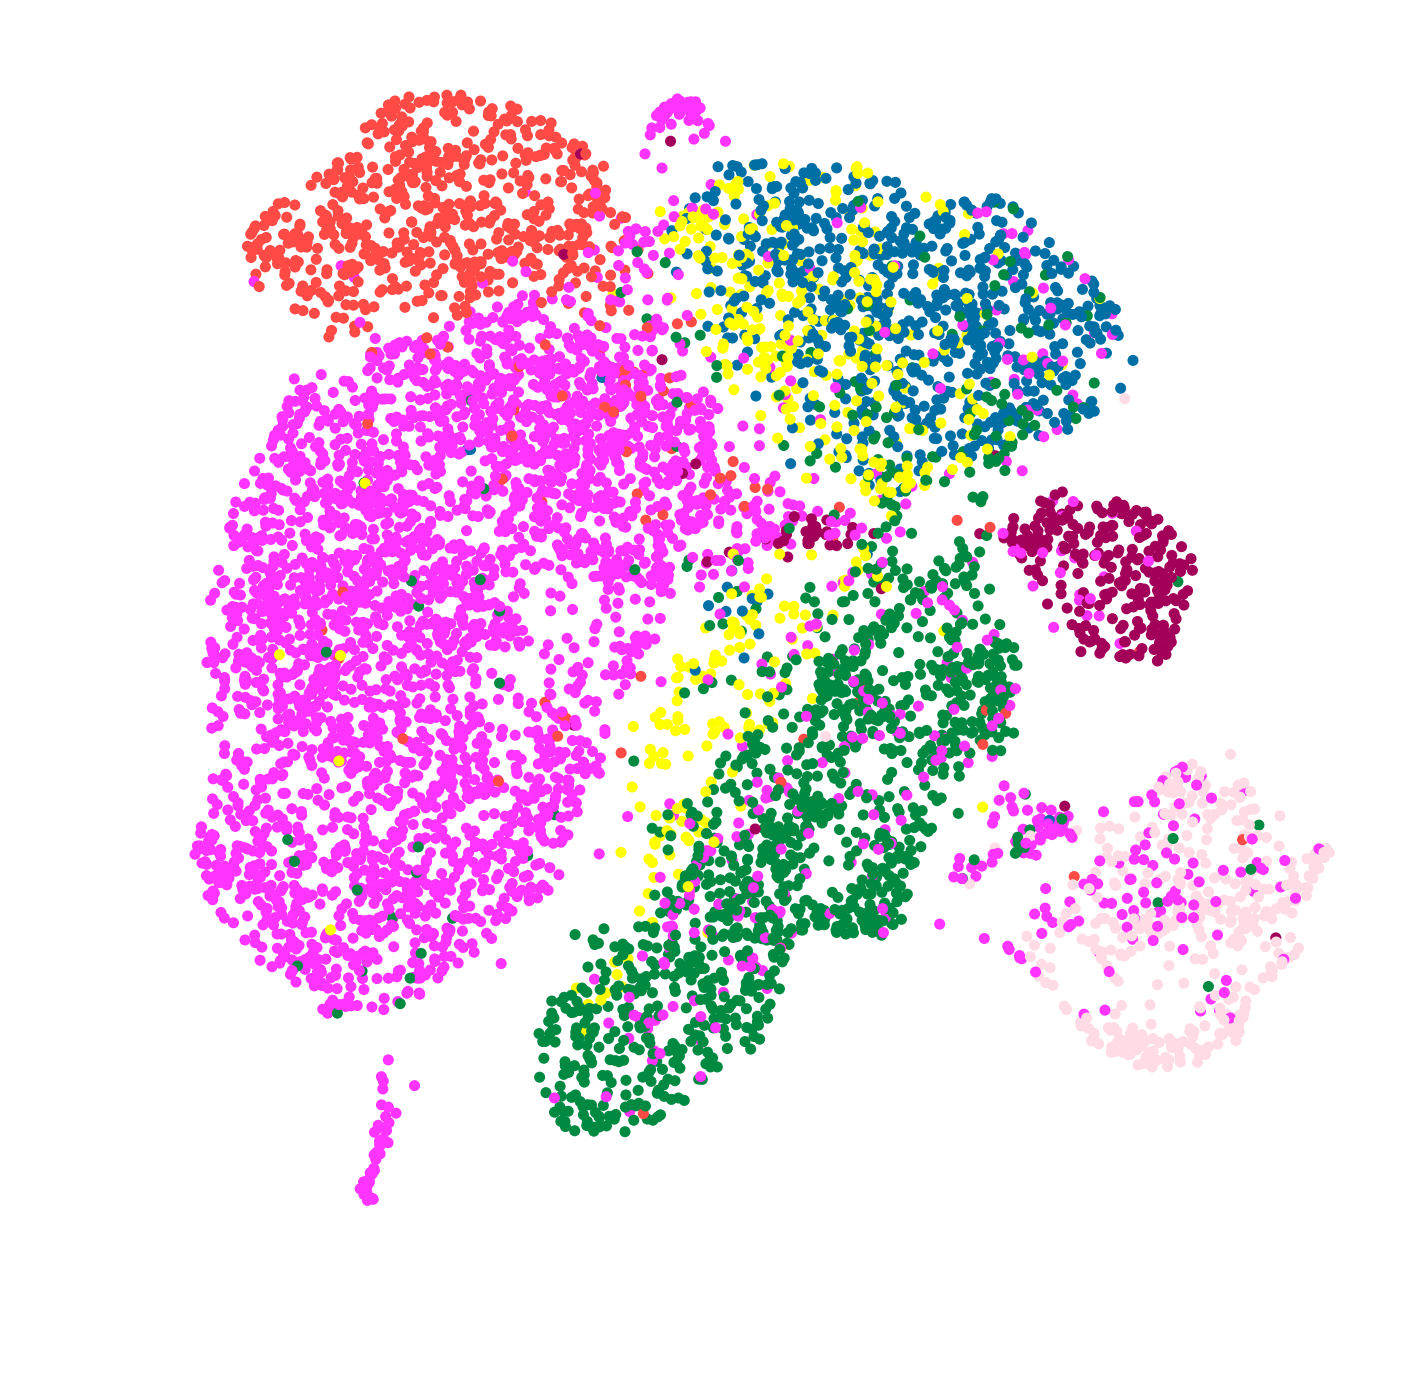

In [56]:
sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", 
           save="_cell_type_before.pdf", palette=palette, legend_loc=None)

# Perfroming architecture Surgery

In [21]:
new_network = sca.operate(network, 
                          new_task_name='after',
                          new_conditions=target_conditions[0],
                          init='Xavier',
                          version='scArches',
                          remove_dropout=True,
                         )

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!
scArches' network has been successfully compiled!


In [22]:
new_network.condition_encoder

{'Pancreas CelSeq (reference)': 0,
 'Pancreas Fluidigm C1 (reference)': 1,
 'Pancreas InDrop (reference)': 2,
 'Pancreas SS2 (query)': 3}

## Train with small new dataset containing out-of-sample condition

In [23]:
target_adata_1 = target_adata[target_adata.obs[condition_key] == target_conditions[0]]
target_adata_1

View of AnnData object with n_obs × n_vars = 2961 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [26]:
new_network.train(target_adata_1,
                  train_size=0.8, 
                  condition_key=condition_key,
                  n_epochs=10000,
                  batch_size=128, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  save=True,
                  retrain=False,
                  )

 |--------------------| 1.6%  - loss: 2.2956 - mmd_loss: 0.0000 - reconstruction_loss: 2.2956 - val_loss: 2.2819 - val_mmd_loss: 0.0000 - val_reconstruction_loss: 2.2819
scArches has been successfully saved in ./models/OoS+IS/pancreas_alpha/before/after.


In [27]:
plot_adata = target_adata_1.concatenate(source_adata)

In [28]:
latent_adata_after = new_network.get_latent(plot_adata, condition_key)
latent_adata_after

AnnData object with n_obs × n_vars = 10545 × 10 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [72]:
sc.pp.neighbors(latent_adata_after)
sc.tl.umap(latent_adata_after)

In [73]:
palette = [batch_colors['Pancreas CelSeq'], 
           batch_colors['Pancreas Fluidigm C1'],
           batch_colors['Pancreas InDrop'],
           batch_colors['Pancreas SS2']
          ]

... storing 'cell_type' as categorical
... storing 'study' as categorical


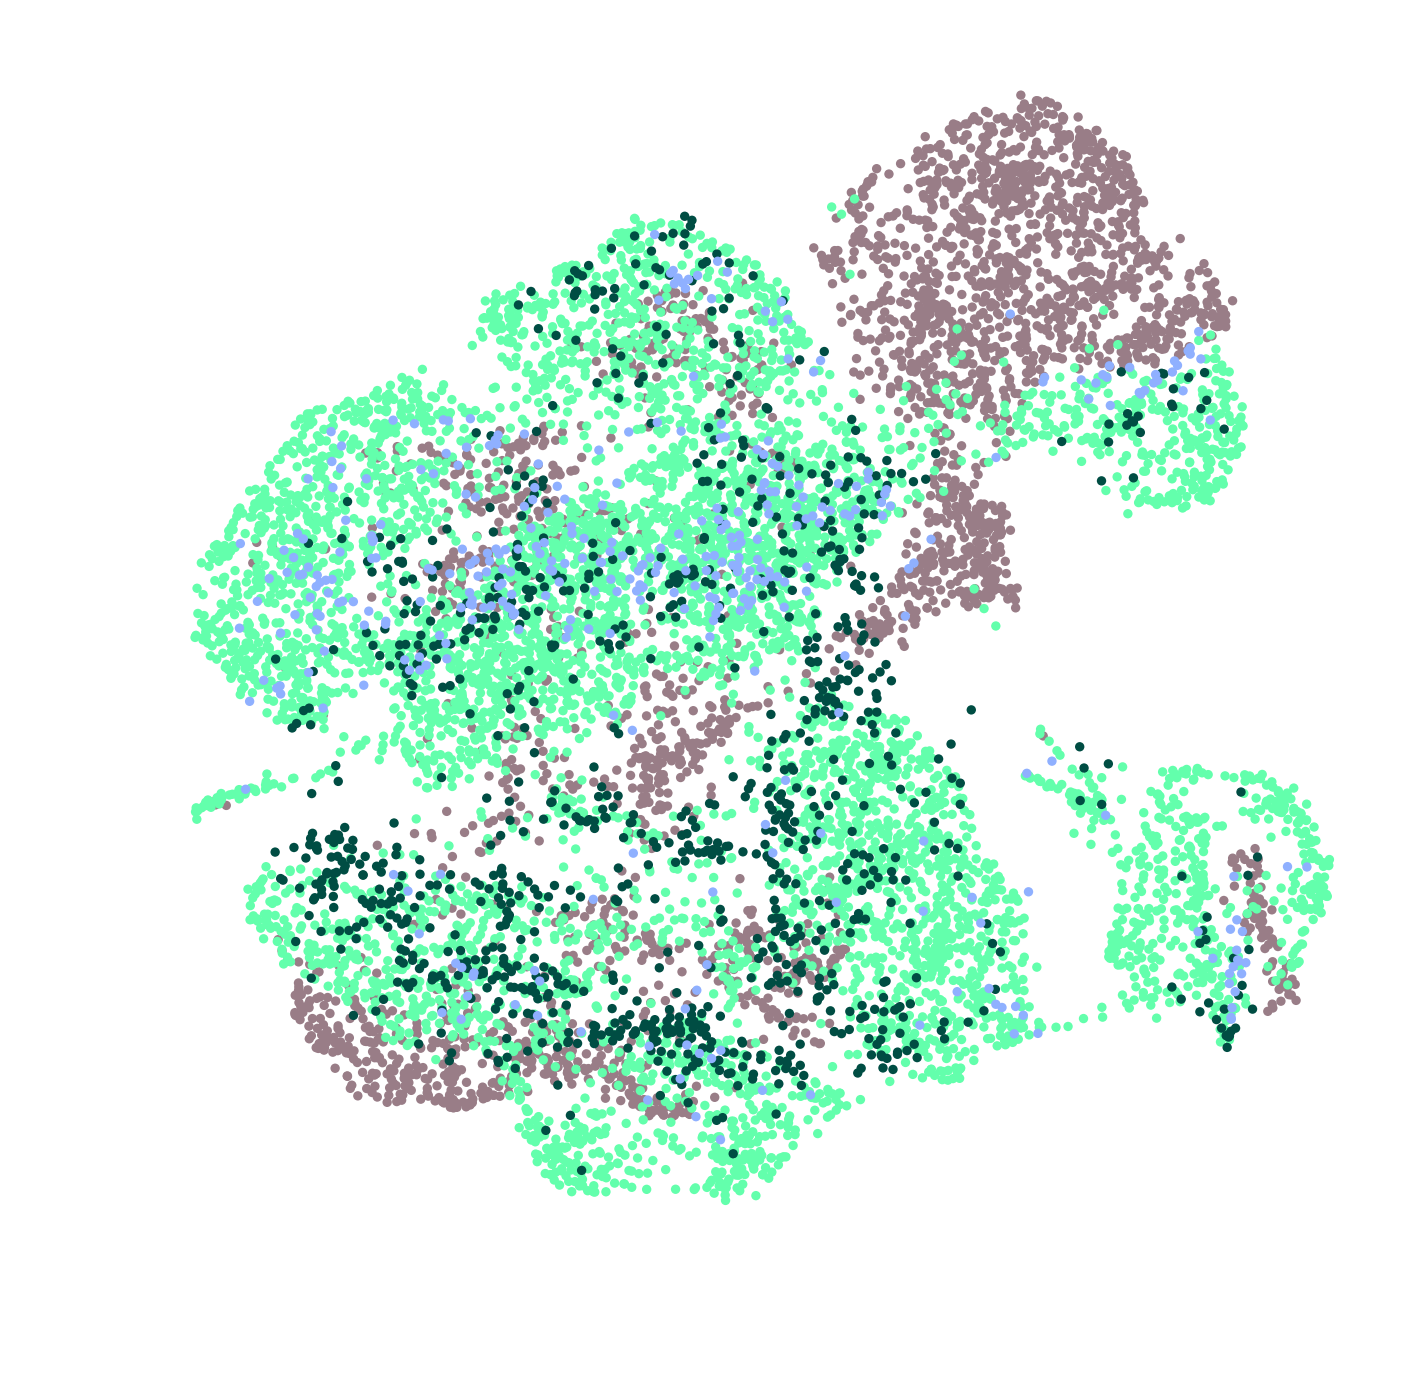

In [74]:
sc.pl.umap(latent_adata_after, color=[condition_key], frameon=False, title="", 
           save="_condition_after_1.pdf", palette=palette, legend_loc=None)

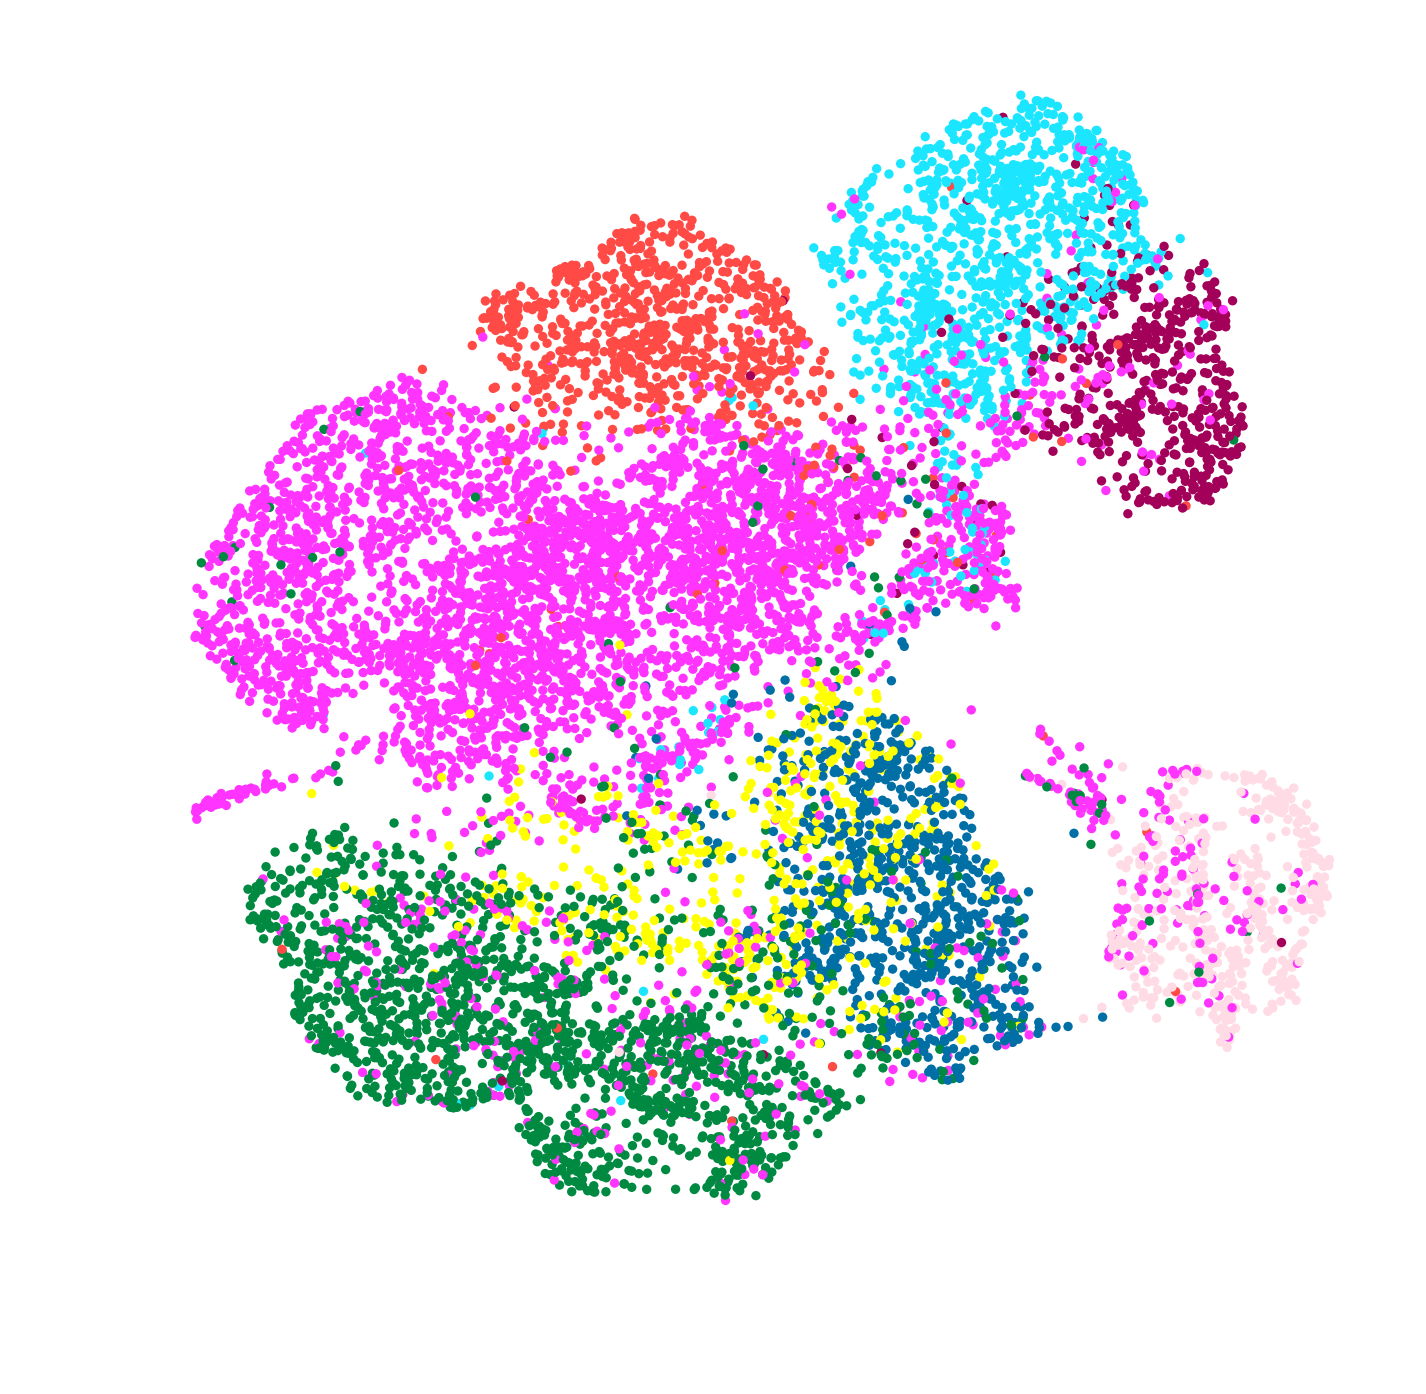

In [75]:
sc.pl.umap(latent_adata_after, color=[cell_type_key], frameon=False, title="", 
           save="_cell_type_after_1.pdf", palette=sc.pl.palettes.godsnot_102, legend_loc=None)

In [30]:
new_network = sca.operate(new_network, 
                          new_task_name='after2',
                          new_conditions=target_conditions[1],
                          init='Xavier',
                          version='scArches',
                         )

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!
scArches' network has been successfully compiled!


In [31]:
new_network.condition_encoder

{'Pancreas CelSeq (reference)': 0,
 'Pancreas Fluidigm C1 (reference)': 1,
 'Pancreas InDrop (reference)': 2,
 'Pancreas SS2 (query)': 3,
 'Pancreas CelSeq2 (query)': 4}

In [32]:
target_adata_2 = target_adata[target_adata.obs[condition_key] == target_conditions[1]]
target_adata_2

View of AnnData object with n_obs × n_vars = 2426 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [33]:
new_network.train(target_adata_2,
                  train_size=0.8, 
                  condition_key=condition_key,
                  n_epochs=10000,
                  batch_size=128, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  save=True,
                  retrain=False,
                  verbose=5)

 |--------------------| 1.0%  - loss: 2.3615 - mmd_loss: 0.0000 - reconstruction_loss: 2.3615 - val_loss: 2.3482 - val_mmd_loss: 0.0000 - val_reconstruction_loss: 2.3482
scArches has been successfully saved in ./models/OoS+IS/pancreas_alpha/before/after2.


In [34]:
plot_adata = source_adata.concatenate(target_adata)
plot_adata

AnnData object with n_obs × n_vars = 12971 × 1000 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [35]:
latent_adata = new_network.get_latent(plot_adata, condition_key)
latent_adata

AnnData object with n_obs × n_vars = 12971 × 10 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [88]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [89]:
palette = [batch_colors['Pancreas CelSeq'], 
           batch_colors['Pancreas CelSeq2'], 
           batch_colors['Pancreas Fluidigm C1'],
           batch_colors['Pancreas InDrop'],
           batch_colors['Pancreas SS2']
          ]

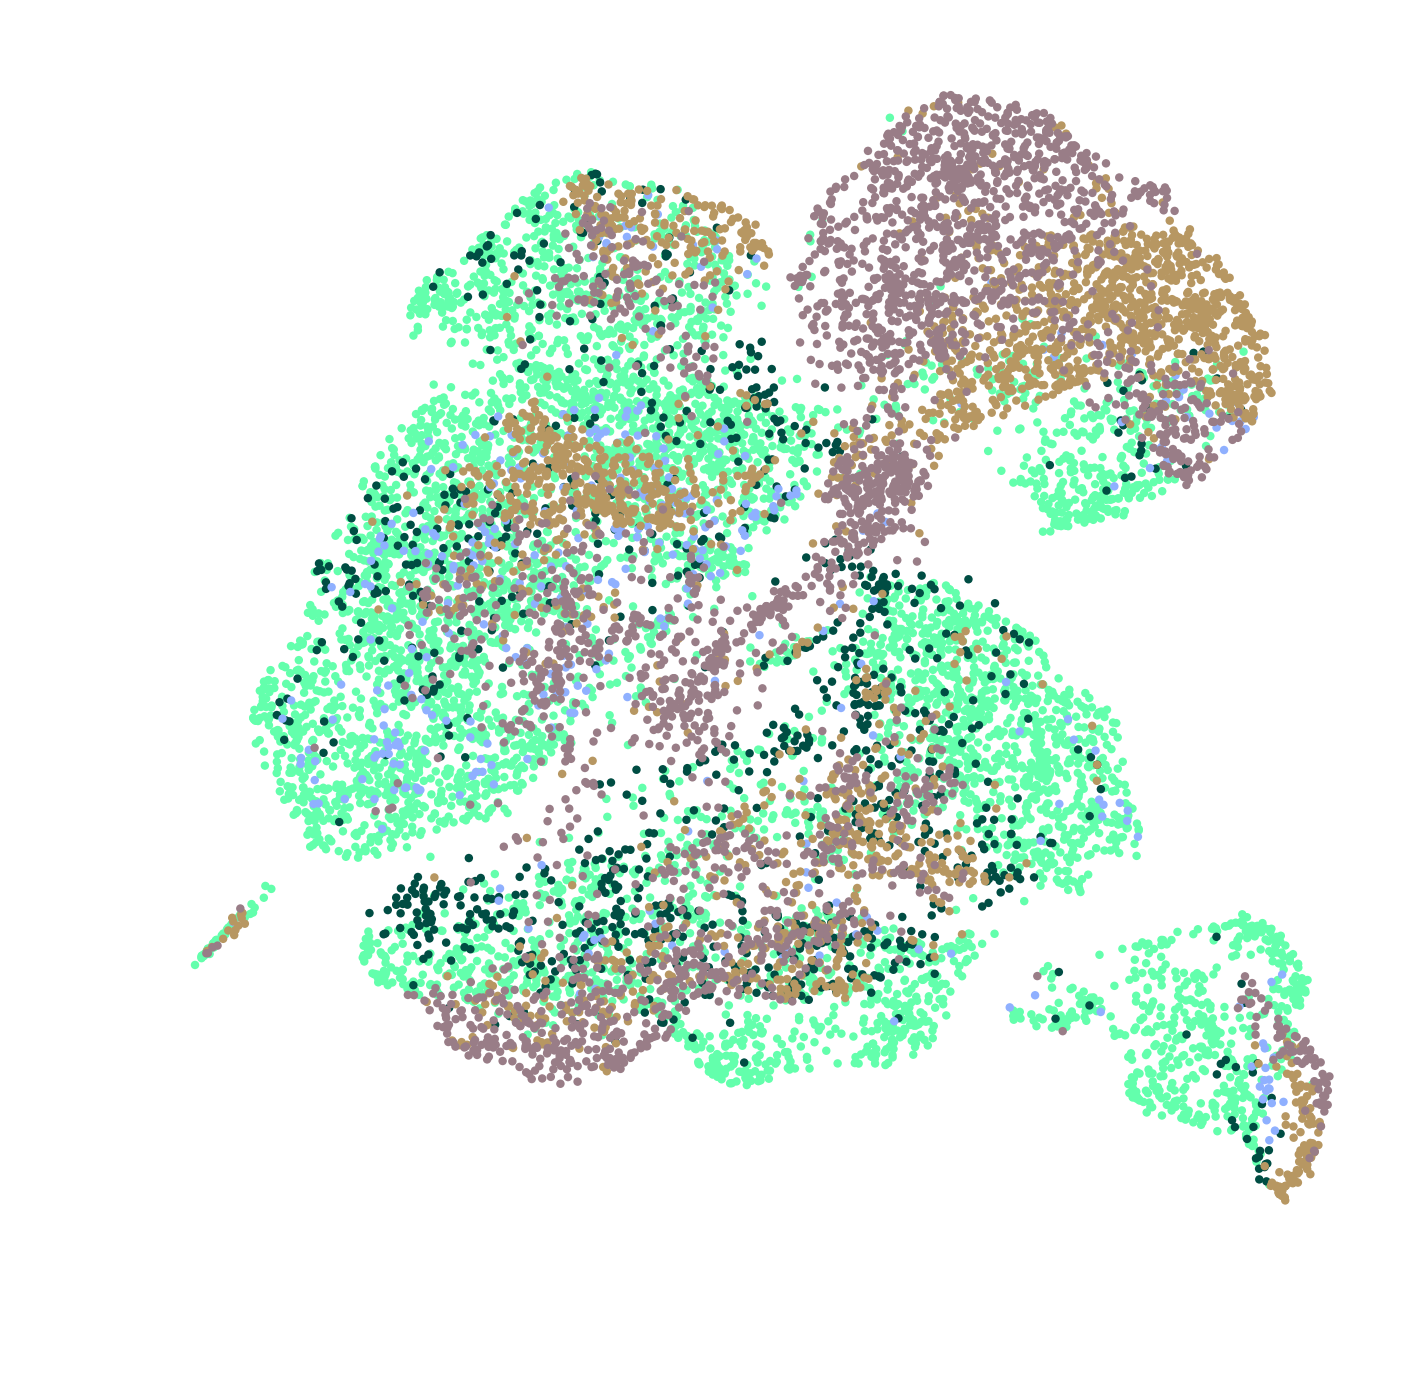

In [92]:
sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", 
           save="_condition_after_2.pdf", palette=palette, legend_loc=None)

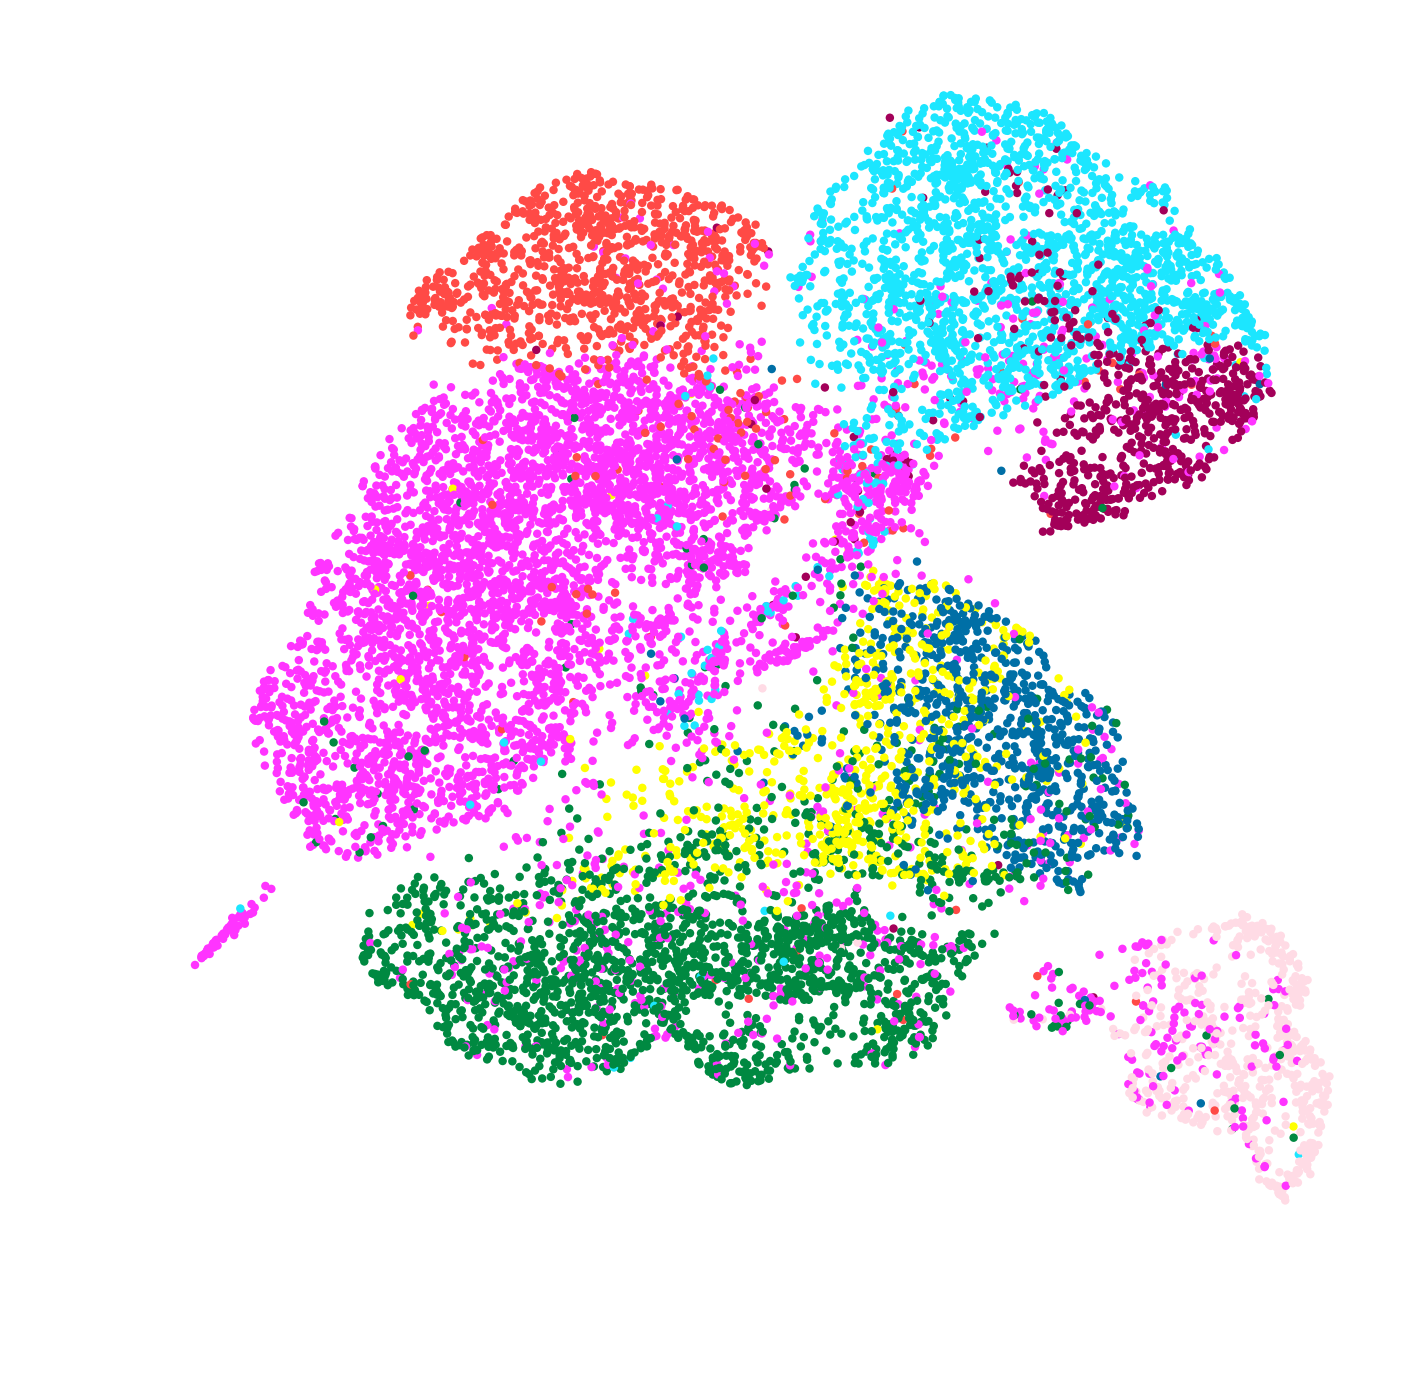

In [93]:
sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", legend_loc=None, 
           save="_cell_type_after_2.pdf", palette=sc.pl.palettes.godsnot_102)